# Safety Dataset EDA and Modeling
by Prince Joseph Erneszer Javier

## Executive Summary

## Introduction

## About the Data

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

from collections import Counter

import warnings
warnings.simplefilter('ignore')

### Preprocessing and Feature Engineering

In [2]:
# check the dataset folders
!ls data/safety/

data_dictionary.xlsx  features	labels


In [ ]:
# read the data dictionary
xl = pd.ExcelFile("data/safety/data_dictionary.xlsx")

In [ ]:
# sheet names
xl.sheet_names

In [ ]:
# let's see the first sheet
xl.parse('telematics data').head()

In [ ]:
# let's see the second sheet
xl.parse('labels').head()

In [ ]:
# let's see the contents of features and labels folder
!ls data/safety/features

# there are many csvs, we either want to run this in Pyspark 
# or we can combine them into just one Pandas dataset

In [ ]:
!ls data/safety/labels

In [ ]:
# let's load one features csv, there are many csvs we either
_ = pd.read_csv("data/safety/features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv")
_.head()

In [ ]:
# let's load the labels csv
labels = pd.read_csv("data/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

# drop duplicates
labels = labels.dropna()

labels.head()

In [ ]:
# how many null
labels.isnull().sum()

In [ ]:
# how many labels are there?
len(labels)

In [ ]:
# how many unique bookings are there?
len(labels.bookingID.unique())

In [ ]:
# load all paths into list
paths = glob.glob("data/safety/features/*.csv")

# let's combine all feature into one pandas dataframe
df_feats0 = pd.DataFrame()

for path in paths:
    _ = pd.read_csv(path, header="infer")
    df_feats0 = pd.concat([df_feats0, _])

In [ ]:
df_feats0.head()

In [ ]:
df_feats0.shape

In [ ]:
# drop duplicates
df_feats0 = df_feats0.drop_duplicates()

In [ ]:
# count null values
df_feats0.isnull().sum()

In [ ]:
# since there is only one label per bookingID, we engineer features per booking trip
# min, max, mean, std, skewness, kurtosis, length_of_trip, 

# sorting by booking number and seconds
df_feats0 = df_feats0.sort_values(by=["bookingID", "second"]).reset_index(drop=True)
df_feats0.head()

In [ ]:
from scipy.stats import kurtosis, skew

In [ ]:
df_feats0.groupby(by="bookingID").agg(np.percentile(p=0.25), np.percentile(p=0.75))

In [ ]:
# we engineer feature, aggregating feature values per bookingID
# getting min, max, mean, std, skewness, and kurtosis

df_engg_feats = df_feats0.drop("second", axis=1)
df_engg_feats = df_engg_feats.groupby(by="bookingID", as_index=True).agg([np.min, np.max, np.mean, np.std, skew, kurtosis])
df_engg_feats.head()

In [ ]:
# flatten column names
cols = [df_engg_feats.columns[i][0]+"_"+df_engg_feats.columns[i][1] for i in range(len(df_engg_feats.columns))]
cols

In [ ]:
df_engg_feats.columns = cols
df_engg_feats.head()

In [ ]:
# add length of each trip
df_len = df_feats.groupby(by="bookingID", as_index=True).agg(len).iloc[:, 0:1]
df_len.columns = ['trip_len']
df_len.head()

In [ ]:
df_engg_feats_2 = pd.concat([df_engg_feats, df_len], axis=1)
df_engg_feats_2.head()

In [ ]:
# save df_engg_feats to csv
df_engg_feats_2.to_csv("data/processed/engg_feats_agg.csv", index=True)

In [ ]:
# # left join with labels (no aggregating)
# df_feats_labels = pd.merge(df_feats, labels, how="outer", on="bookingID")

# # save to CSV
# save_path = "data/feats_labels.csv"
# df_feats_labels.to_csv(save_path, index=False)

In [ ]:
# left join with labels (aggregating and feature engineering)
df_engg_feats_labels = pd.merge(df_engg_feats_2, labels, how="inner", on="bookingID")

# save to CSV
save_path = "data/processed/engg_feats_labels.csv"
df_engg_feats_labels.to_csv(save_path, index=False)

In [ ]:
df_engg_feats_labels.shape

In [ ]:
df_engg_feats_labels.head()

In [ ]:
df_engg_feats_labels.info()

In [2]:
# load saved combined dataset
save_path = "data/processed/engg_feats_labels.csv"
df_engg_feats_labels0 = pd.read_csv(save_path)
df_engg_feats_labels0.drop("bookingID", axis=1, inplace=True)
df_engg_feats_labels0.head()

,Accuracy_amin,Accuracy_amax,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,Bearing_mean,Bearing_std,...,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len,label
0,4.0,48.000,10.165339,3.855898,1.732696,8.764958,0.037464,359.979767,176.526099,129.231351,...,-0.991564,20.752428,-1.0,22.946083,8.994822,7.199919,0.167588,-1.431322,1004.0,0
1,3.0,7.709,3.718763,0.597933,1.259239,5.437314,0.000000,337.000000,124.198590,89.861236,...,0.811801,5.634003,-1.0,21.882141,7.881588,7.059362,0.347213,-1.243763,851.0,1
2,3.0,8.000,3.930626,1.117354,1.325234,0.930249,1.000000,354.000000,173.794872,119.316520,...,1.543345,12.962534,0.0,9.360483,3.157213,2.897762,0.407362,-1.068416,195.0,1
3,10.0,10.000,10.000000,0.000000,0.000000,-3.000000,2.271227,353.855377,151.807013,71.273774,...,0.547003,7.147706,0.0,19.780001,6.150996,5.595901,0.872207,-0.638173,1094.0,1
4,3.0,12.000,4.586721,1.329545,1.697510,5.095780,0.000000,359.000000,197.812785,111.868249,...,-0.034414,6.984716,0.0,16.394695,4.628921,5.314844,0.723716,-1.001236,1095.0,0


In [3]:
df_feats = df_engg_feats_labels0.drop("label", axis=1)
df_feats.head()

,Accuracy_amin,Accuracy_amax,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,Bearing_mean,Bearing_std,...,gyro_z_std,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len
0,4.0,48.000,10.165339,3.855898,1.732696,8.764958,0.037464,359.979767,176.526099,129.231351,...,0.063685,-0.991564,20.752428,-1.0,22.946083,8.994822,7.199919,0.167588,-1.431322,1004.0
1,3.0,7.709,3.718763,0.597933,1.259239,5.437314,0.000000,337.000000,124.198590,89.861236,...,0.033838,0.811801,5.634003,-1.0,21.882141,7.881588,7.059362,0.347213,-1.243763,851.0
2,3.0,8.000,3.930626,1.117354,1.325234,0.930249,1.000000,354.000000,173.794872,119.316520,...,0.036215,1.543345,12.962534,0.0,9.360483,3.157213,2.897762,0.407362,-1.068416,195.0
3,10.0,10.000,10.000000,0.000000,0.000000,-3.000000,2.271227,353.855377,151.807013,71.273774,...,0.065927,0.547003,7.147706,0.0,19.780001,6.150996,5.595901,0.872207,-0.638173,1094.0
4,3.0,12.000,4.586721,1.329545,1.697510,5.095780,0.000000,359.000000,197.812785,111.868249,...,0.057438,-0.034414,6.984716,0.0,16.394695,4.628921,5.314844,0.723716,-1.001236,1095.0


## EDA

In [5]:
# basic_stats = df_feats.describe().T
# basic_stats

In [6]:
# # we look at scatterplots between the features using a sample of 100 points
# df_sample = df_engg_feats_labels0.sample(n=100)
# sns.pairplot(df_sample, hue='label')

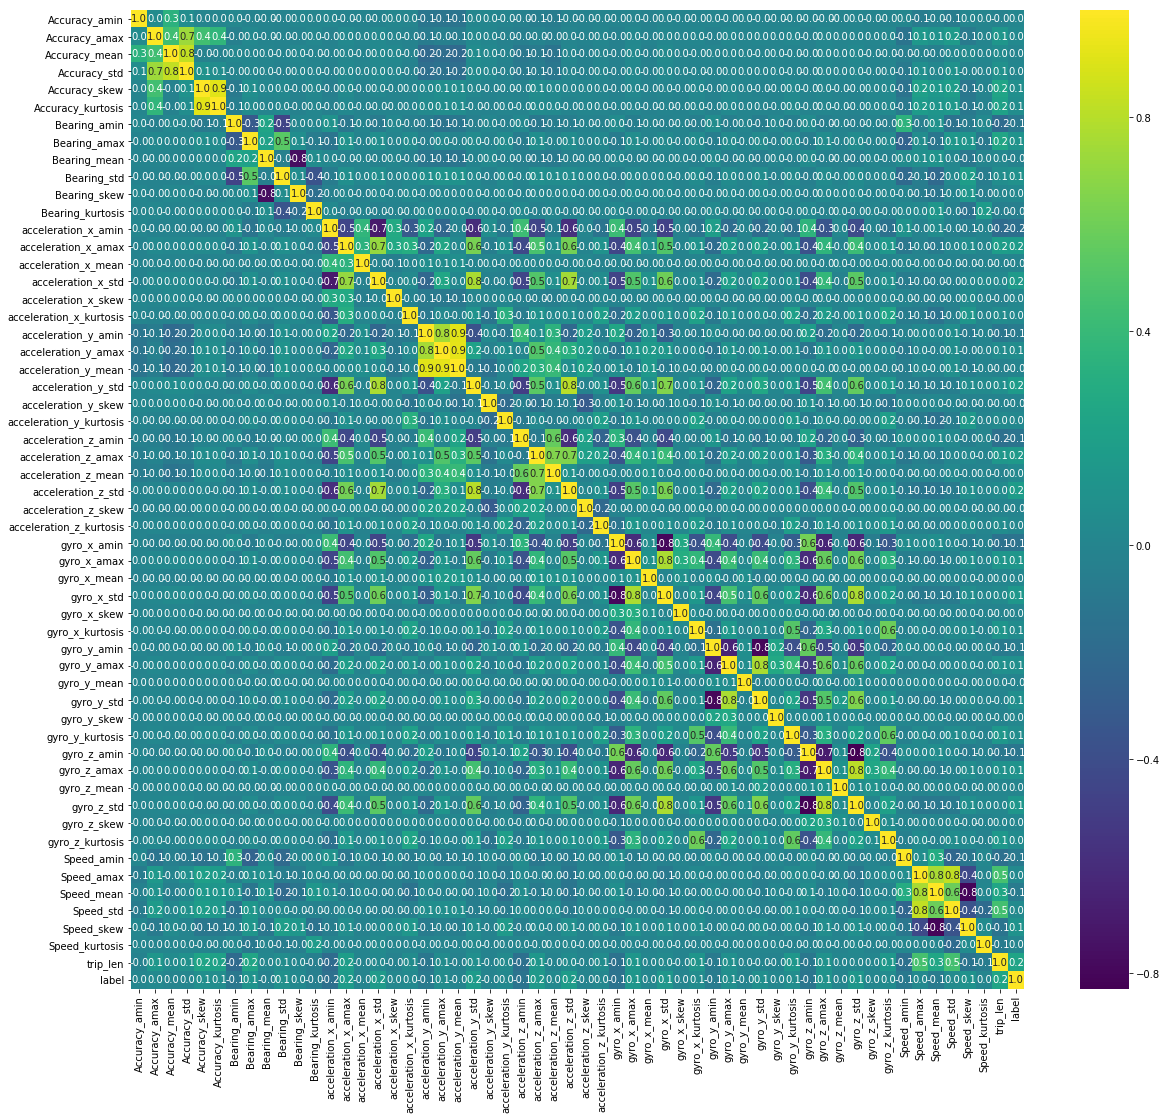

In [7]:
# we look at the correlations between the features using a covariance matrix
plt.figure(figsize=(20, 18))

df_corr_matrix = pd.DataFrame(np.corrcoef(df_engg_feats_labels0.values.T), 
                              index=df_engg_feats_labels0.columns, columns=df_engg_feats_labels0.columns)
sns.heatmap(df_corr_matrix, annot=True, fmt='0.1f', cmap="viridis")

In [8]:
# # boxplots
# plt.semilogy()
# sns.boxplot(x="label", y="Accuracy", data=df_feats_labels)
# plt.show()

In [9]:
# # boxplots
# data = df_feats_labels

# sns.distplot()
# plt.show()

Counter({0: 15017, 1: 5001})


Text(0, 0.5, 'counts')

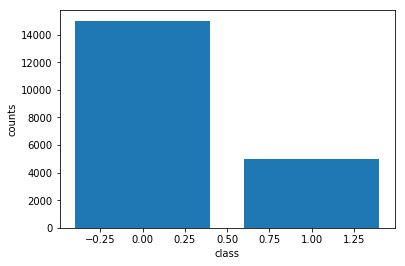

In [10]:
# number of samples per class
print(Counter(df_engg_feats_labels0.label))
y = Counter(df_engg_feats_labels0.label).values()
x = Counter(df_engg_feats_labels0.label).keys()

plt.bar(x, y)
plt.xlabel("class")
plt.ylabel("counts")

## Preprocessing for Models

In [4]:
from sklearn.utils import shuffle

In [5]:
# equalizing the number of classes
# getting number of samples for class 1 (lower)
num_per_class = len(df_engg_feats_labels0[df_engg_feats_labels0.label == 1])
print(num_per_class)

# getting a sample for class 1
df_labels_1 = df_engg_feats_labels0[df_engg_feats_labels0.label == 1].sample(n=num_per_class, replace=False, random_state=42)

# getting a sample for class 0
df_labels_0 = df_engg_feats_labels0[df_engg_feats_labels0.label == 0].sample(n=num_per_class, replace=False, random_state=42)
print(len(df_labels_0))

5001
5001


In [6]:
# concatenate and shuffle
df_for_ml = shuffle(pd.concat([df_labels_1, df_labels_0]), random_state=42).reset_index(drop=True)

# shape
df_for_ml.shape

(10002, 56)

Counter({0: 5001, 1: 5001})


Text(0, 0.5, 'counts')

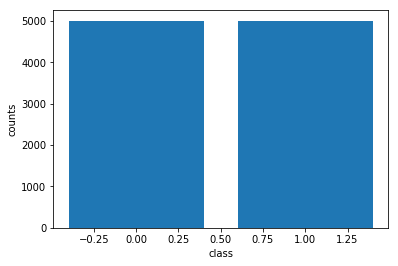

In [7]:
# number of samples per class
print(Counter(df_for_ml.label))
y = Counter(df_for_ml.label).values()
x = Counter(df_for_ml.label).keys()

plt.bar(x, y)
plt.xlabel("class")
plt.ylabel("counts")

In [8]:
# train-test splitting
from sklearn.model_selection import train_test_split

X = df_for_ml.drop("label", axis=1)
y = df_for_ml.label

feature_cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [9]:
# saving train and test datasets to CSV files
X_train.to_csv(f"data/processed/X_train_{num_per_class}.csv", index=False)
pd.DataFrame(y_train).to_csv(f"data/processed/y_train_{num_per_class}.csv", index=False)
X_test.to_csv(f"data/processed/X_test_{num_per_class}.csv", index=False)
pd.DataFrame(y_test).to_csv(f"data/processed/y_test_{num_per_class}.csv", index=False)

In [10]:
X_train.head()

,Accuracy_amin,Accuracy_amax,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,Bearing_mean,Bearing_std,...,gyro_z_std,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len
4375,5.538,19.013,10.208456,2.297102,0.042381,-0.033659,0.0,357.0,159.239601,89.121688,...,1.453180,16.197613,504.120852,0.0,25.480000,13.183120,9.606290,-0.221962,-1.618660,1202.0
6699,3.000,227.011,4.037249,6.766145,31.800856,1042.100579,0.0,349.0,187.412909,84.546642,...,0.018971,-0.568326,5.157358,-1.0,27.310000,13.021282,8.276575,-0.211214,-1.205694,1131.0
9807,3.000,12.000,4.011150,1.198717,2.037806,5.176472,0.0,359.0,150.987936,62.577832,...,0.028358,0.016865,3.283961,0.0,26.007350,8.598508,9.184211,0.607227,-1.198558,746.0
1101,3.000,1200.000,7.229739,57.713387,18.113116,348.053387,0.0,359.0,216.786294,80.544214,...,0.083714,0.774482,9.296440,-1.0,22.934992,9.763993,8.287888,0.130746,-1.575047,1109.0
9539,3.000,12.485,4.810422,1.974101,2.173935,4.886012,0.0,359.0,219.853211,123.486673,...,0.042491,1.026991,9.928158,-1.0,31.199860,9.825829,10.263194,0.615364,-1.061141,654.0


In [11]:
X_test.head()

,Accuracy_amin,Accuracy_amax,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,Bearing_mean,Bearing_std,...,gyro_z_std,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len
8606,3.0,8.391,4.004431,0.970454,2.496676,6.776681,0.00000,355.000000,157.344870,75.335067,...,0.033330,1.570197,10.039042,0.00,21.364538,8.715181,6.471265,0.216391,-1.230089,809.0
4684,3.0,38.592,4.269997,2.767686,7.991289,74.241857,0.00000,359.000000,107.510025,127.186579,...,0.022215,2.759855,39.543976,-1.00,25.840000,10.815727,8.694203,0.115695,-1.524800,798.0
1731,10.0,30.000,10.028540,0.691596,27.184667,768.119159,11.47489,358.719421,197.868203,92.645812,...,0.049196,0.037153,4.397883,0.16,18.570000,7.060845,5.213331,0.530168,-1.078048,911.0
4742,3.0,8.000,3.656092,0.758157,1.950838,5.168846,38.00000,308.000000,219.285544,63.883105,...,0.043203,-0.476902,8.352040,0.00,20.890152,6.778761,6.859656,0.510766,-1.189454,837.0
4521,3.0,12.000,3.565319,0.876595,3.046777,16.636378,52.00000,276.000000,143.082803,59.160215,...,0.066085,-1.068978,10.420801,0.00,23.797161,4.467340,6.733916,1.198001,-0.018637,1256.0


In [12]:
y_train.head()

4375    0
6699    1
9807    1
1101    1
9539    1
Name: label, dtype: int64

In [13]:
y_test.head()

8606    0
4684    0
1731    1
4742    0
4521    1
Name: label, dtype: int64

In [14]:
# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mmsc = MinMaxScaler()
stdsc = StandardScaler()

In [15]:
# scale the training set minmax/standard
scaler = "minmax"

if scaler == "std":
    sc = stdsc.fit(X_train)
else:
    sc = mmsc.fit(X_train)
    
X_train = sc.transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_cols)

X_train.head()

,Accuracy_amin,Accuracy_amax,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Bearing_amin,Bearing_amax,Bearing_mean,Bearing_std,...,gyro_z_std,gyro_z_skew,gyro_z_kurtosis,Speed_amin,Speed_amax,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,trip_len
0,0.003388,0.003301,0.005481,0.002153,0.200997,0.001131,0.0,0.991671,0.461564,0.526368,...,0.406862,0.653474,0.325802,0.083755,0.177696,0.464339,0.728431,0.491792,0.007611,0.145411
1,0.001592,0.048376,0.001418,0.006341,0.716972,0.398612,0.0,0.969448,0.543226,0.499347,...,0.003679,0.402732,0.004129,0.041877,0.189976,0.459040,0.627601,0.492285,0.009887,0.135869
2,0.001592,0.001782,0.001401,0.001123,0.233417,0.003119,0.0,0.997226,0.437646,0.369595,...,0.006318,0.411484,0.002921,0.083755,0.181235,0.314244,0.696425,0.529842,0.009926,0.084128
3,0.001592,0.259230,0.003520,0.054088,0.494590,0.133895,0.0,0.997226,0.628366,0.475708,...,0.021879,0.422814,0.006797,0.041877,0.160617,0.352400,0.628458,0.507977,0.007852,0.132912
4,0.001592,0.001887,0.001927,0.001850,0.235628,0.003008,0.0,0.997226,0.637256,0.729333,...,0.010291,0.426591,0.007204,0.041877,0.216079,0.354425,0.778243,0.530216,0.010683,0.071765


In [16]:
# PCA?
# are there visible clusters if we perform and look at it in 3d?
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents)

In [17]:
len(X.columns)

55

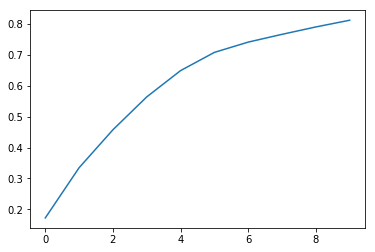

array([0.17203678, 0.3346983 , 0.45766559, 0.56416937, 0.64933045,
       0.70839867, 0.74168748, 0.76687993, 0.79082409, 0.81254152])

In [18]:
# explained variance ratio of first 10 principal components
# first 10 principal components explain 80% of the variance
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]))
plt.show()
np.cumsum(pca.explained_variance_ratio_[:10])

In [19]:
# plot in 3D with label colors
principalDf.iloc[:, 0:3].head()

,0,1,2
0,0.114539,0.122454,-0.298118
1,0.103313,-0.334774,-0.089581
2,0.089133,-0.184714,0.090404
3,0.095102,-0.258667,-0.049079
4,0.175496,-0.202403,-0.210217


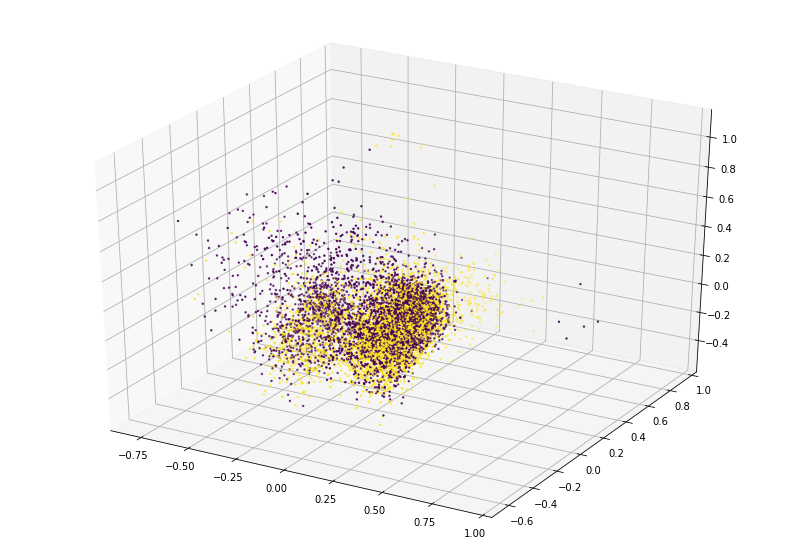

In [39]:
# plotting on the first 3 principal components
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(principalDf.iloc[:, 0], principalDf.iloc[:, 1], principalDf.iloc[:, 2], c=y_train, cmap='viridis', s=2)

## Accuracy to Beat - PCC

In [20]:
# proportional chance criterion
state_counts = Counter(y)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
num = (df_state[0] / df_state[0].sum())**2
pcc = num.sum()
pcc

0.5

## Machine Learning Models

In [26]:
# loading packages
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [27]:
models_results = {'model':[], 'valid_acc':[], 'params':[]}
n_jobs = 18

### Logistic Regression

In [28]:
param_grid = {'penalty':['l1', 'l2'], 'C':[0.01, 0.1, 0.5, 0.75, 1., 10, 100]}

clf = LogisticRegression()

logreg = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
logreg.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.639114784695374
Best parameters: {'C': 100, 'penalty': 'l1'}


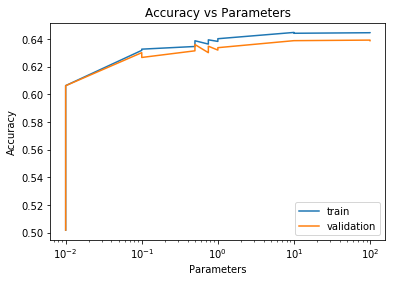

In [29]:
# calculate results
model = logreg
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['log_reg']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/log_reg_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Linear SVC L1

In [30]:
param_grid = {'penalty':['l1'], 'dual':[False], 'C':[0.01, 0.1, 0.5, 0.75, 1., 10, 100, 1000]}

clf = LinearSVC()

lsvcl1 = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
lsvcl1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'penalty': ['l1'], 'dual': [False], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6405812558325557
Best parameters: {'C': 10, 'dual': False, 'penalty': 'l1'}


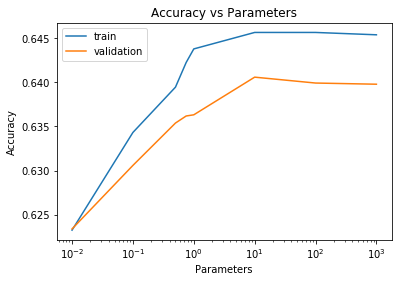

In [31]:
# calculate results
model = lsvcl1
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['linear_svc_l1']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/linear_svc_l1_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Linear SVC L2

In [32]:
param_grid = {'penalty':['l2'], 'loss':['hinge'], 'C':[0.01, 0.1, 0.5, 0.75, 1., 10, 100]}

clf = LinearSVC()

lsvcl2 = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
lsvcl2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'penalty': ['l2'], 'loss': ['hinge'], 'C': [0.01, 0.1, 0.5, 0.75, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.642847620317291
Best parameters: {'C': 10, 'loss': 'hinge', 'penalty': 'l2'}


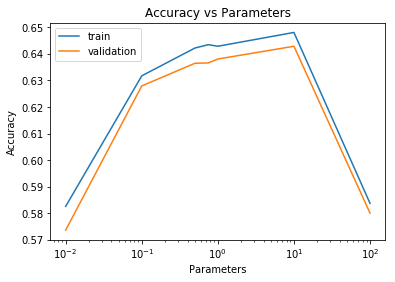

In [33]:
# calculate results
model = lsvcl2
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['linear_svc_l2']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/linear_svc_l2_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Nonlinear SVC

In [34]:
param_grid = {'C':[0.1, 0.5, 0.75, 1., 10, 100, 1000, 2000]}

clf = SVC()

svc = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'C': [0.1, 0.5, 0.75, 1.0, 10, 100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6451139848020264
Best parameters: {'C': 1000}


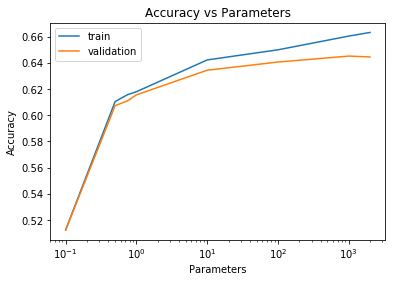

In [35]:
# calculate results
model = svc
results = pd.DataFrame(model.cv_results_)
params = results.param_C
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['svc']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/svc_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### GBM

In [36]:
param_grid = {'learning_rate':[0.01, 0.05, 0.1], "n_estimators":[500], "max_depth":[2, 3, 4, 5]}

clf = GradientBoostingClassifier()

gbm = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
gbm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [500], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6407145713904813
Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}


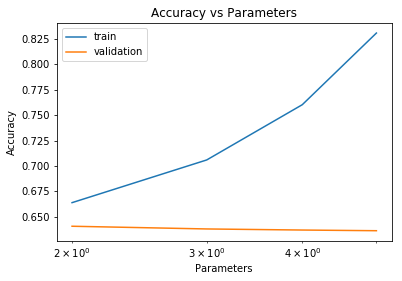

In [37]:
# calculate results
model = gbm
results = pd.DataFrame(model.cv_results_)
params = results[results.param_learning_rate==0.01].param_max_depth
train_score = results[results.param_learning_rate==0.01].mean_train_score
valid_score = results[results.param_learning_rate==0.01].mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['gbm']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/gbm_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Random Forest

In [38]:
param_grid = {'min_samples_split':[2, 3, 4], "max_depth":[2, 3, 4, 5]}

clf = RandomForestClassifier()

rf = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6289828022930276
Best parameters: {'max_depth': 5, 'min_samples_split': 3}


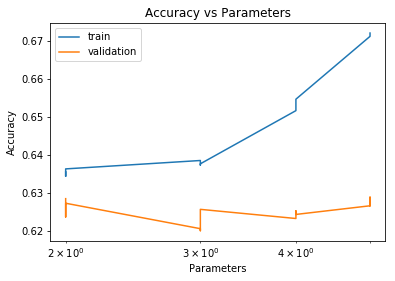

In [39]:
# calculate results
model = rf
results = pd.DataFrame(model.cv_results_)
params = results.param_max_depth
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['random_forest']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/rf_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Decision Tree

In [40]:
param_grid = {'min_samples_split':[2, 3, 4], "max_depth":[2, 3, 4, 5]}

clf = DecisionTreeClassifier()

dt = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.6205839221437142
Best parameters: {'max_depth': 3, 'min_samples_split': 3}


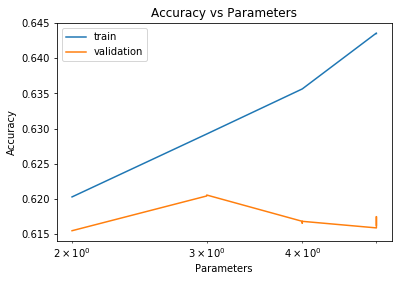

In [41]:
# calculate results
model = dt
results = pd.DataFrame(model.cv_results_)
params = results.param_max_depth
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['decision_tree']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/dt_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

### Naive Bayes

In [42]:
param_grid = {'var_smoothing':[1e-9, 1e-5, 1e-1]}
clf = GaussianNB()

nb = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)
nb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'var_smoothing': [1e-09, 1e-05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best validation accuracy: 0.5565924543394214
Best parameters: {'var_smoothing': 1e-05}


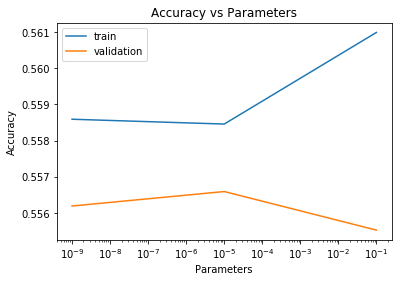

In [43]:
# calculate results
model = nb
results = pd.DataFrame(model.cv_results_)
params = results.param_var_smoothing
train_score = results.mean_train_score
valid_score = results.mean_test_score

# plot
plt.semilogx()
plt.plot(params, train_score, label="train")
plt.plot(params, valid_score, label="validation")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Parameters")
plt.legend()

# saving to dictionary of models and results
models_results["model"] += ['naive_bayes']
models_results["params"] += [model.best_params_]
models_results["valid_acc"] += [model.best_score_]

# print accuracies and parameters
print("Best validation accuracy:", model.best_score_)
print("Best parameters:", model.best_params_)

# save the model to disk
filename = f'models/nb_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

In [44]:
results = pd.DataFrame(models_results).sort_values(by="valid_acc", ascending=False)

In [47]:
# save to csv
results.to_csv(f"results/ml_results_{scaler}.csv", index=False)

In [48]:
# results from standard scaler
pd.set_option('display.max_colwidth', -1)
pd.read_csv("results/ml_results_std.csv")

,model,valid_acc,params
0,linear_svc_l2,0.644847,"{'C': 0.75, 'loss': 'hinge', 'penalty': 'l2'}"
1,linear_svc_l1,0.641381,"{'C': 0.1, 'dual': False, 'penalty': 'l1'}"
2,gbm,0.641248,"{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}"
3,svc,0.641115,{'C': 0.75}
4,log_reg,0.640048,"{'C': 1.0, 'penalty': 'l1'}"
5,random_forest,0.629783,"{'max_depth': 4, 'min_samples_split': 2}"
6,decision_tree,0.620184,"{'max_depth': 3, 'min_samples_split': 2}"
7,naive_bayes,0.556193,{'var_smoothing': 1e-09}


In [49]:
# results from minmax scaler
pd.set_option('display.max_colwidth', -1)
pd.read_csv("results/ml_results_minmax.csv")

,model,valid_acc,params
0,svc,0.645114,{'C': 1000}
1,linear_svc_l2,0.642848,"{'C': 10, 'loss': 'hinge', 'penalty': 'l2'}"
2,gbm,0.640715,"{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}"
3,linear_svc_l1,0.640581,"{'C': 10, 'dual': False, 'penalty': 'l1'}"
4,log_reg,0.639115,"{'C': 100, 'penalty': 'l1'}"
5,random_forest,0.628983,"{'max_depth': 5, 'min_samples_split': 3}"
6,decision_tree,0.620584,"{'max_depth': 3, 'min_samples_split': 3}"
7,naive_bayes,0.556592,{'var_smoothing': 1e-05}


### Most Predictive Features According to the Best ML Model

<BarContainer object of 55 artists>

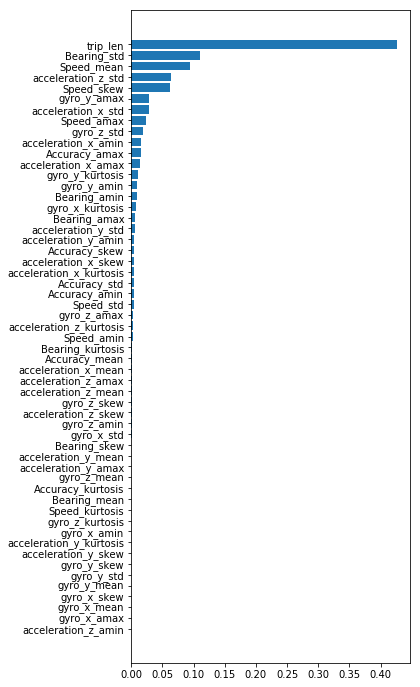

In [50]:
# GBM can be used for feature importances
plt.figure(figsize=(5, 12))
y = gbm.best_estimator_.feature_importances_
inds = np.argsort(y)
y = y[inds]
x = feature_cols[inds]
plt.barh(x, y)

## Incremental Adding of Features from Most Predictive

In [51]:
# feats from most important down
top_feats = x[::-1]
top_feats

Index(['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std',
       'Speed_skew', 'gyro_y_amax', 'acceleration_x_std', 'Speed_amax',
       'gyro_z_std', 'acceleration_x_amin', 'Accuracy_amax',
       'acceleration_x_amax', 'gyro_y_kurtosis', 'gyro_y_amin', 'Bearing_amin',
       'gyro_x_kurtosis', 'Bearing_amax', 'acceleration_y_std',
       'acceleration_y_amin', 'Accuracy_skew', 'acceleration_x_skew',
       'acceleration_x_kurtosis', 'Accuracy_std', 'Accuracy_amin', 'Speed_std',
       'gyro_z_amax', 'acceleration_z_kurtosis', 'Speed_amin',
       'Bearing_kurtosis', 'Accuracy_mean', 'acceleration_x_mean',
       'acceleration_z_amax', 'acceleration_z_mean', 'gyro_z_skew',
       'acceleration_z_skew', 'gyro_z_amin', 'gyro_x_std', 'Bearing_skew',
       'acceleration_y_mean', 'acceleration_y_amax', 'gyro_z_mean',
       'Accuracy_kurtosis', 'Bearing_mean', 'Speed_kurtosis',
       'gyro_z_kurtosis', 'gyro_x_amin', 'acceleration_y_kurtosis',
       'acceleration_y_skew', 'g

### Linear SVC L2

In [52]:
param_grid = {'penalty':['l2'], 'loss':['hinge'], 'C':[10]}
clf = LinearSVC()
lsvcl2_b = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_b = []
best_score = 0

# checking features one by one
for i in range(len(top_feats)):
    feats_b += [top_feats[i]]
    X_train_b = X_train[feats_b]

    lsvcl2_b.fit(X_train_b, y_train)

    # calculate results
    model = lsvcl2_b
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)
        
    else:
        feats_b = feats_b[:-1]
        
print(feats_b)
# save the model to disk
filename = f'models/linear_svc_l2_feat_selection_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.6092520997200374
Best validation accuracy: 0.6111185175309959
Best validation accuracy: 0.6213838154912679
Best validation accuracy: 0.6335155312624984
Best validation accuracy: 0.6361818424210105
Best validation accuracy: 0.6379149446740434
Best validation accuracy: 0.6384482069057459
Best validation accuracy: 0.6387148380215971
Best validation accuracy: 0.6389814691374484
Best validation accuracy: 0.6399146780429276
['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'gyro_z_std', 'Accuracy_amax', 'Accuracy_amin', 'acceleration_z_kurtosis', 'gyro_z_skew']


### Nonlinear SVC

In [53]:
param_grid = {'C':[1000]}
clf = SVC()
svc_b = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_b = []
best_score = 0

# checking features one by one
for i in range(len(top_feats)):
    feats_b += [top_feats[i]]
    X_train_b = X_train[feats_b]

    svc_b.fit(X_train_b, y_train)

    # calculate results
    model = svc_b
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)
        
    else:
        feats_b = feats_b[:-1]
        
print(feats_b)

# save the model to disk
filename = f'models/svc_feat_selection_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.6020530595920544
Best validation accuracy: 0.6136515131315825
Best validation accuracy: 0.6267164378082922
Best validation accuracy: 0.6355152646313825
Best validation accuracy: 0.64044794027463
Best validation accuracy: 0.6467137714971337
Best validation accuracy: 0.6492467670977203
Best validation accuracy: 0.6496467137714972
Best validation accuracy: 0.6499133448873483
Best validation accuracy: 0.6523130249300093
['trip_len', 'Bearing_std', 'Speed_mean', 'acceleration_z_std', 'Speed_skew', 'Speed_amax', 'acceleration_x_skew', 'Speed_amin', 'acceleration_x_mean', 'acceleration_z_mean']


### GBM

In [ ]:
param_grid = {'learning_rate':[0.01], "n_estimators":[1000], "max_depth":[2]}

clf = GradientBoostingClassifier()

gbm_b = GridSearchCV(clf, param_grid = param_grid, return_train_score=True, cv=3, n_jobs=n_jobs)

valid_accs = []
feats_b = []
best_score = 0

# checking features one by one
for i in range(len(top_feats)):
    feats_b += [top_feats[i]]
    X_train_b = X_train[feats_b]

    gbm_b.fit(X_train_b, y_train)

    # calculate results
    model = gbm_b
    results = pd.DataFrame(model.cv_results_)
    valid_score = results.mean_test_score.values[0]

    if valid_score > best_score:
        best_score = valid_score
        valid_accs.append(valid_score)

        # print accuracies and parameters
        print("Best validation accuracy:", best_score)
        
    else:
        feats_b = feats_b[:-1]
        
print(feats_b)

# save the model to disk
filename = f'models/gbm_feat_selection_{scaler}.sav'
pickle.dump(model, open(filename, 'wb'))

Best validation accuracy: 0.606985735235302
Best validation accuracy: 0.6136515131315825
Best validation accuracy: 0.6236501799760032
Best validation accuracy: 0.6284495400613251
Best validation accuracy: 0.6353819490734569
Best validation accuracy: 0.6371150513264898
Best validation accuracy: 0.6395147313691508
Best validation accuracy: 0.64044794027463
Best validation accuracy: 0.641514464738035
Best validation accuracy: 0.6437808292227702


## Neural Networks